In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import matplotlib
matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams ['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family']= 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3
matplotlib.rcParams['figure.facecolor'] = (1,1,1)

In [2]:
signals_mc_spec = [ # name, weight, energy, ewidth, radius, rwidth
    ('A',10,3,1,3,1),
    ('B',10,3,1,7,1),
    ('C',10,7,1,3,1),
    ('D',10,7,1,7,1)
]

poisson_means = [200,100,100,50]

def gen_fake(filename,energy,ewidth,radius,rwidth,num=1000):
    e = np.random.normal(energy,ewidth,num)
    r = np.random.normal(radius,rwidth,num)
    data = np.asarray([e,r]).T
    if filename:
        np.save(filename,data)
    else:
        return data
    
for name, weight, energy, ewidth, radius, rwidth in signals_mc_spec:
    for i in range(weight):
        gen_fake('data/%s_%i.npy'%(name,i),energy, ewidth, radius, rwidth)

for i in range(250):
    means = np.random.poisson(poisson_means)
    data = []
    for j, (name, weight, energy, ewidth, radius, rwidth) in enumerate(signals_mc_spec):
        s_data = gen_fake(None, energy, ewidth, radius, rwidth, num=means[j])
        data.append(s_data)
    data = np.concatenate(data)
    np.save('data/raw_data_%i.npy'%i,data)

In [3]:
from kdfit.calculate import System
from kdfit.analysis import Analysis

In [4]:
a = Analysis()
obs = a.add_observables('Scint_Phase')
e_scale,e_shift,e_res = obs.add_dimension('Energy',0,0,10)
r_scale,r_shift,r_res = obs.add_dimension('Radius',1,0,10)
A_sig = obs.add_signal('A')
B_sig = obs.add_signal('B')
C_sig = obs.add_signal('C')
D_sig = obs.add_signal('D')

In [5]:
A_sig.nev_param.value = 200
B_sig.nev_param.value = 100
C_sig.nev_param.value = 100
D_sig.nev_param.value = 50

In [6]:
mc_files = dict(Scint_Phase=dict(A=glob('data/A_*.npy'),
                                B=glob('data/B_*.npy'),
                                C=glob('data/C_*.npy'),
                                D=glob('data/D_*.npy')))

In [7]:
%prun a.load_mc(mc_files)

rough int 1.0045007097473497


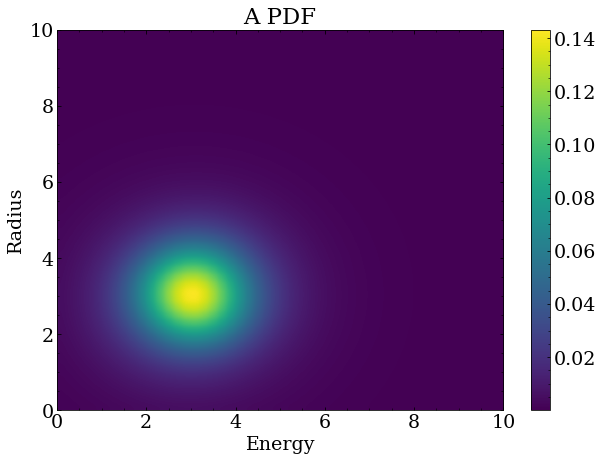

rough int 1.0045234051519087


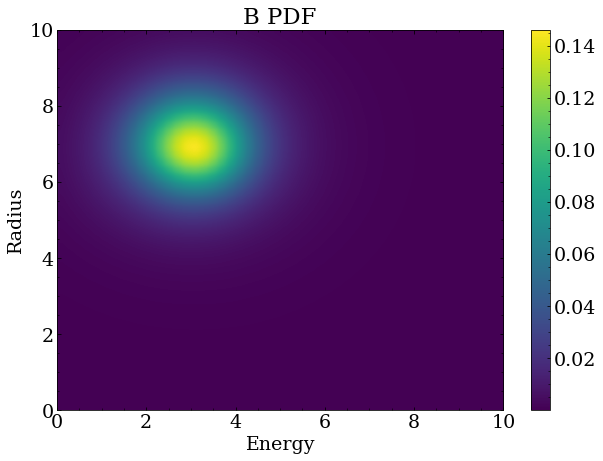

rough int 1.0047500001360619


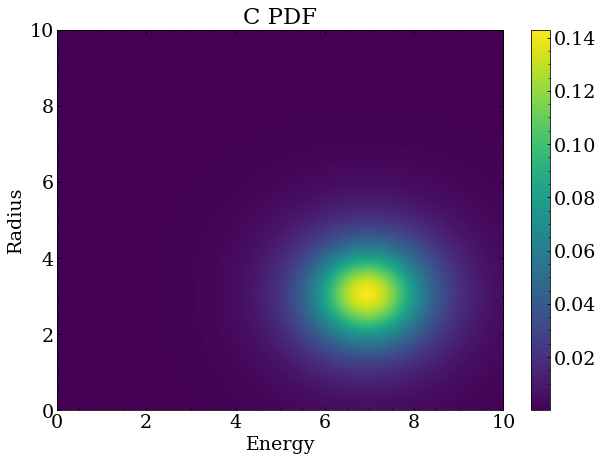

rough int 1.0045378920736179


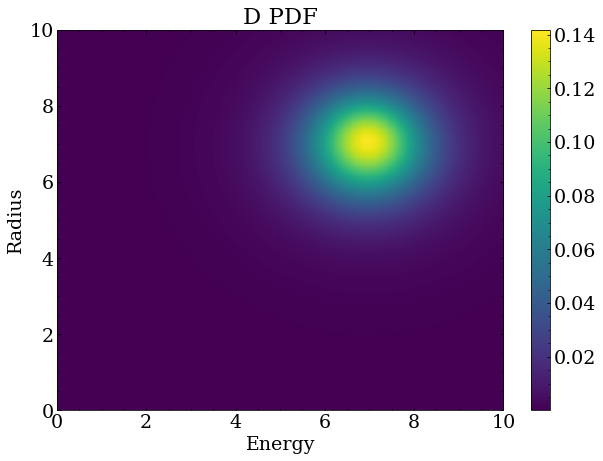

In [8]:
for s in obs.signals.values():
    Xv,Yv = np.linspace(obs.lows[0],obs.highs[0],50),np.linspace(obs.lows[1],obs.highs[1],50)
    X,Y = np.meshgrid(Xv,Yv)
    x_kj = list(zip(X.flatten(),Y.flatten()))
    Z = s.eval_pdf_multi(x_kj)
    print('rough int',np.sum(Z)*(Xv[1]-Xv[0])*(Yv[1]-Yv[0]))
    Z = np.asarray(Z).reshape(X.shape)
    plt.imshow(Z,extent=[np.min(Xv),np.max(Xv),np.max(Yv),np.min(Yv)],aspect='auto',interpolation='gaussian')
    plt.colorbar()
    #plt.scatter(*(s.t_ij.T if np == cp else s.t_ij.T.get()),c='r',marker='x')
    plt.xlim(obs.lows[0],obs.highs[0])
    plt.ylim(obs.lows[1],obs.highs[1])
    plt.xlabel(obs.dimensions[0])
    plt.ylabel(obs.dimensions[1])
    plt.title('%s PDF'%s.name)
    plt.show()
    plt.close()

In [9]:
def gauss(x,m,s):
    return 1/np.sqrt(2*np.pi)/s*np.exp(-np.square((x-m)/s)/2)
from scipy.special import erf
def analytic_norm(energy,ewidth,radius,rwidth):
    a = obs.lows
    b = obs.highs
    m = np.asarray([energy,radius])
    s = np.asarray([ewidth,rwidth])
    d = 2
    return np.prod( erf((b-m)/s/np.sqrt(2)) - erf((a-m)/s/np.sqrt(2))  )/(2**d)
def analytic_pdf(x_kj,energy,ewidth,radius,rwidth):
    return gauss(x_kj[:,0],energy,ewidth)*gauss(x_kj[:,1],radius,rwidth)/analytic_norm(energy,ewidth,radius,rwidth)

rough int 0.2315991990179827


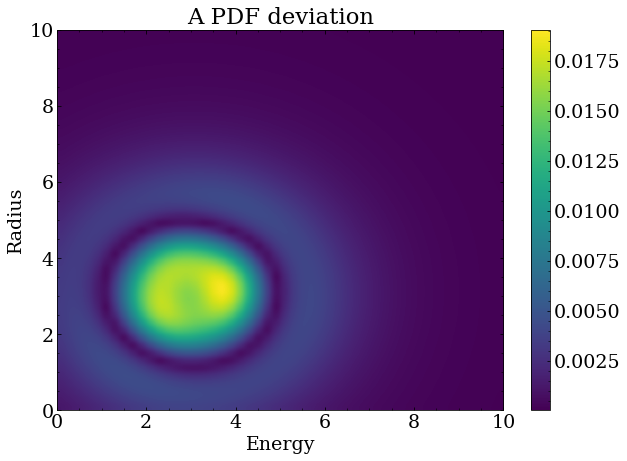

rough int 0.22707226088694166


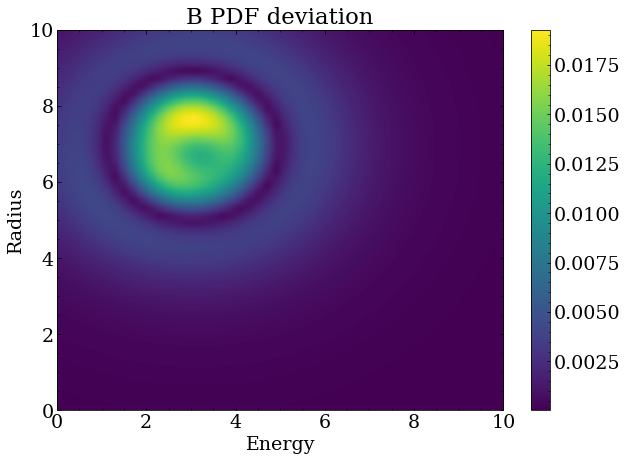

rough int 0.24314229895209058


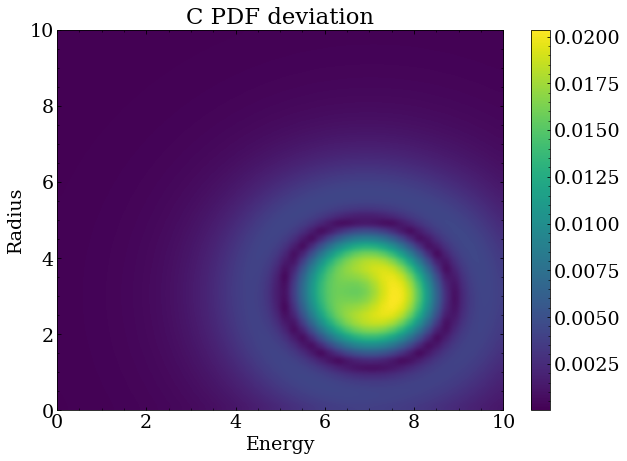

rough int 0.23635658155716407


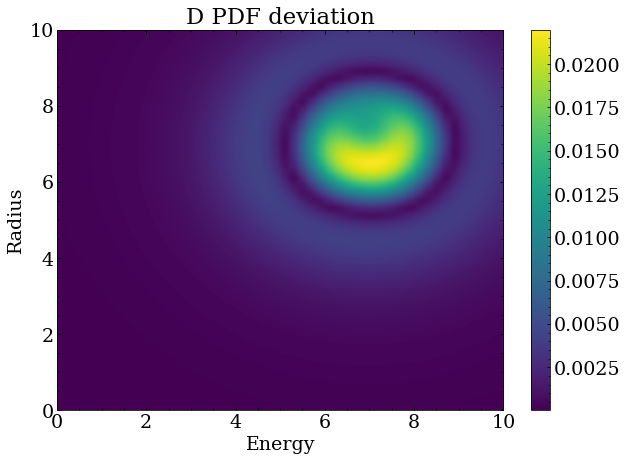

In [10]:
#The structure in the deviations is utterly bizarre to me
for j,s in enumerate(obs.signals.values()):
    name, weight, energy, ewidth, radius, rwidth = signals_mc_spec[j]
    Xv,Yv = np.linspace(obs.lows[0],obs.highs[0],50),np.linspace(obs.lows[1],obs.highs[1],50)
    X,Y = np.meshgrid(Xv,Yv)
    x_kj = np.asarray(list(zip(X.flatten(),Y.flatten())))
    Z = s.eval_pdf_multi(x_kj)
    analytic_Z = analytic_pdf(x_kj,energy,ewidth,radius,rwidth)
    Z = np.abs(Z - analytic_Z)
    print('rough int',np.sum(Z)*(Xv[1]-Xv[0])*(Yv[1]-Yv[0]))
    Z = np.asarray(Z).reshape(X.shape)
    plt.imshow(Z,extent=[np.min(Xv),np.max(Xv),np.max(Yv),np.min(Yv)],aspect='auto',interpolation='gaussian')
    plt.colorbar()
    #plt.scatter(*(s.t_ij.T if np == cp else s.t_ij.T.get()),c='r',marker='x')
    plt.xlim(obs.lows[0],obs.highs[0])
    plt.ylim(obs.lows[1],obs.highs[1])
    plt.xlabel(obs.dimensions[0])
    plt.ylabel(obs.dimensions[1])
    plt.title('%s PDF deviation'%s.name)
    plt.show()
    plt.close()

In [11]:
a.load_data(dict(Scint_Phase=['data/raw_data_0.npy']))

rough int 1.0045652824043287


Text(0, 0.5, 'Radius')

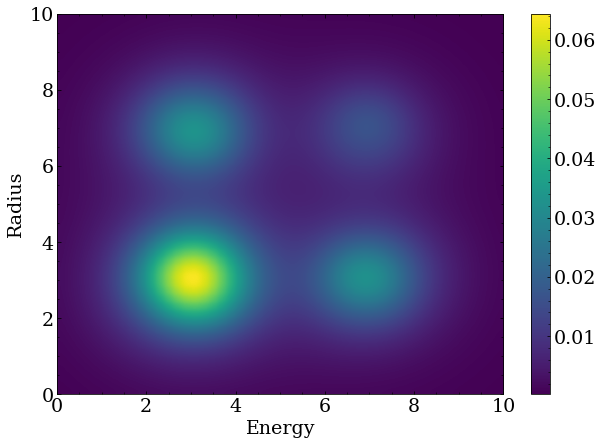

In [12]:
Xv,Yv = np.linspace(obs.lows[0],obs.highs[0],50),np.linspace(obs.lows[1],obs.highs[1],50)
X,Y = np.meshgrid(Xv,Yv)
x_kj = list(zip(X.flatten(),Y.flatten()))
Z = obs.eval_pdf_multi(x_kj)
print('rough int',np.sum(Z)*(Xv[1]-Xv[0])*(Yv[1]-Yv[0]))
Z = np.asarray(Z).reshape(X.shape)
plt.imshow(Z,extent=[np.min(Xv),np.max(Xv),np.max(Yv),np.min(Yv)],aspect='auto',interpolation='gaussian')
plt.colorbar()    
#plt.scatter(*obs.x_ij.T,c='r',marker='x')
plt.xlim(obs.lows[0],obs.highs[0])
plt.ylim(obs.lows[1],obs.highs[1])
plt.xlabel(obs.dimensions[0])
plt.ylabel(obs.dimensions[1])

In [13]:
A_sig.nev_param.value = 200
A_sig.nev_param.constant = False
B_sig.nev_param.value = 100
B_sig.nev_param.constant = False
C_sig.nev_param.value = 100
C_sig.nev_param.constant = False
D_sig.nev_param.value = 50
D_sig.nev_param.constant = False
a.create_likelihood(verbose=True)

Floated Parameters: [A_nev, B_nev, C_nev, D_nev]
Ouput Values: [Total_Likelihood]
Scint_Phase_UnbinnedLikelihood => Total_Likelihood
A_nev => Scint_Phase_UnbinnedLikelihood
B_nev => Scint_Phase_UnbinnedLikelihood
C_nev => Scint_Phase_UnbinnedLikelihood
D_nev => Scint_Phase_UnbinnedLikelihood
A => Scint_Phase_UnbinnedLikelihood
B => Scint_Phase_UnbinnedLikelihood
C => Scint_Phase_UnbinnedLikelihood
D => Scint_Phase_UnbinnedLikelihood
Energy_scale => A
Energy_shift => A
Energy_resolution => A
Radius_scale => A
Radius_shift => A
Radius_resolution => A
Energy_scale => B
Energy_shift => B
Energy_resolution => B
Radius_scale => B
Radius_shift => B
Radius_resolution => B
Energy_scale => C
Energy_shift => C
Energy_resolution => C
Radius_scale => C
Radius_shift => C
Radius_resolution => C
Energy_scale => D
Energy_shift => D
Energy_resolution => D
Radius_scale => D
Radius_shift => D
Radius_resolution => D
Evaluation order: [A B C D Scint_Phase_UnbinnedLikelihood Total_Likelihood]


In [14]:
margs = dict(method='Nelder-Mead',options=dict(fatol=0.001,xatol=0.1))

In [15]:
%prun m = a.minimize(**margs)
print(m)

  final_simplex: (array([[217.50393385, 105.31765228, 103.13959994,  47.02630172],
       [217.56487314, 105.28127285, 103.16687801,  47.01260919],
       [217.58122487, 105.3121417 , 103.13933458,  47.02211817],
       [217.55629695, 105.34463447, 103.16451465,  47.01491542],
       [217.51552841, 105.31424821, 103.17124289,  47.0507846 ]]), array([-549.99767442, -549.99767374, -549.99767102, -549.99766894,
       -549.99766514]))
           fun: -549.9976744196722
       message: 'Optimization terminated successfully.'
          nfev: 69
           nit: 35
        params: {A_nev: 217.5039338459813, B_nev: 105.31765228316203, C_nev: 103.13959994289552, D_nev: 47.02630172097794}
        status: 0
       success: True
             x: array([217.50393385, 105.31765228, 103.13959994,  47.02630172])


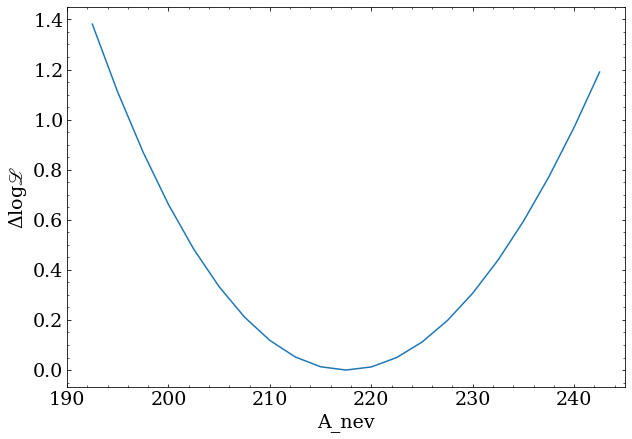

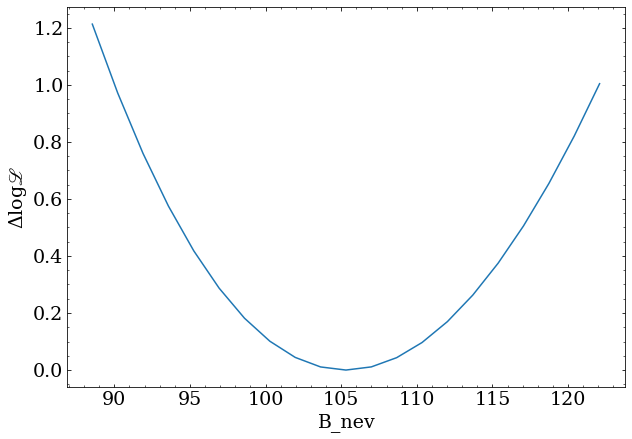

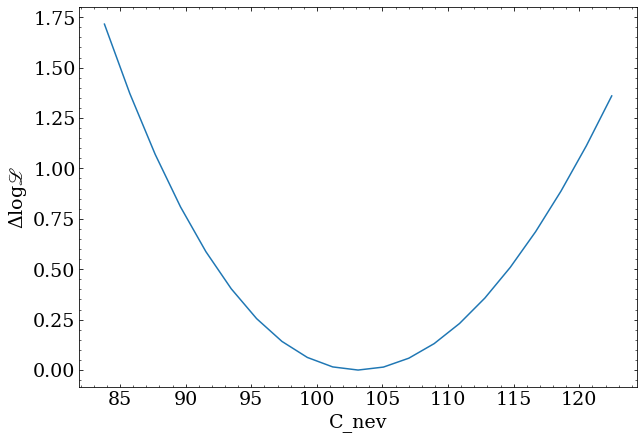

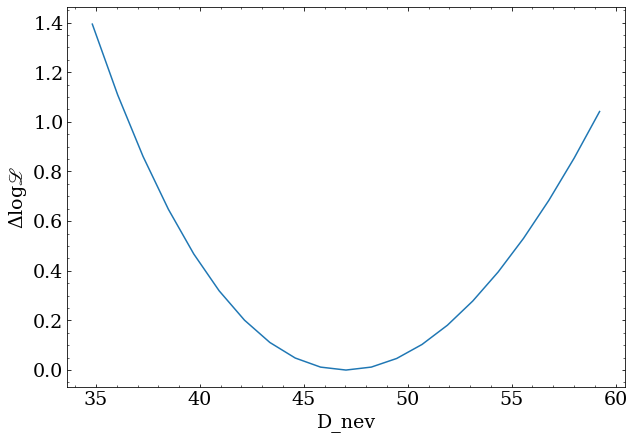

In [16]:
for _p,_v in m.params.items():
    _p.value = _v
    _p.constant = False
for p,v in m.params.items():
    p.constant = True
    a.create_likelihood()
    for step in np.logspace(-2,5,100):
        p.value = v*(1-step)
        if a() - m.fun < 1:
            continue
        p.value = v*(1+step)
        if a() - m.fun < 1:
            continue
        break
    X = np.linspace(v*(1-step),v*(1+step),21)
    Y = []
    for x in X:
        p.value = x
        nll = a() - m.fun
        Y.append(nll)
    p.constant = False
    p.value = v
    plt.plot(X,Y)
    plt.xlabel(p.name)
    plt.ylabel(r'$\Delta$log$\scrL$')
    plt.show()
    plt.close()

In [17]:
%prun a.confidence_intervals(m,method='scan')
print(m)

  final_simplex: (array([[217.50393385, 105.31765228, 103.13959994,  47.02630172],
       [217.56487314, 105.28127285, 103.16687801,  47.01260919],
       [217.58122487, 105.3121417 , 103.13933458,  47.02211817],
       [217.55629695, 105.34463447, 103.16451465,  47.01491542],
       [217.51552841, 105.31424821, 103.17124289,  47.0507846 ]]), array([-549.99767442, -549.99767374, -549.99767102, -549.99766894,
       -549.99766514]))
           fun: -549.9976744196722
         lower: {A_nev: 15.268000432160363, B_nev: 10.97248754480266, C_nev: 10.72919097106616, D_nev: 7.558819127728427}
       message: 'Optimization terminated successfully.'
          nfev: 69
           nit: 35
        params: {A_nev: 217.5039338459813, B_nev: 105.31765228316203, C_nev: 103.13959994289552, D_nev: 47.02630172097794}
        status: 0
       success: True
         upper: {A_nev: 16.023308178074444, B_nev: 11.6752225278928, C_nev: 11.487140704484958, D_nev: 8.282217313920036}
             x: array([217.50

In [18]:
minima = []
for i in range(250):
    a.load_data(dict(Scint_Phase=['data/raw_data_%i.npy'%i]))
    a.create_likelihood()
    m = a.minimize(**margs)
    m = a.confidence_intervals(m,method='scan')
    minima.append(m)
    print(m)

 final_simplex: (array([[217.50393385, 105.31765228, 103.13959994,  47.02630172],
       [217.5745249 , 105.29705621, 103.14556158,  47.00408796],
       [217.49527101, 105.32163098, 103.15945512,  46.99598695],
       [217.56381895, 105.27101115, 103.16112038,  47.0064947 ],
       [217.5367718 , 105.26997531, 103.12602364,  47.01452934]]), array([-549.99767442, -549.99767318, -549.99767313, -549.99767186,
       -549.99767092]))
           fun: -549.9976744196722
         lower: {A_nev: 15.268000432160363, B_nev: 10.97248754480266, C_nev: 10.72919097106616, D_nev: 7.558819127728427}
       message: 'Optimization terminated successfully.'
          nfev: 81
           nit: 49
        params: {A_nev: 217.5039338459813, B_nev: 105.31765228316203, C_nev: 103.13959994289552, D_nev: 47.02630172097794}
        status: 0
       success: True
         upper: {A_nev: 16.023308178074444, B_nev: 11.6752225278928, C_nev: 11.487140704484958, D_nev: 8.282217313920036}
             x: array([217.503

 final_simplex: (array([[201.30617674, 102.96575417,  96.68926039,  38.96343309],
       [201.32755394, 103.02210879,  96.67418319,  39.02076408],
       [201.27021113, 103.04094717,  96.78169381,  38.97257446],
       [201.22040903, 102.96504002,  96.6550994 ,  38.99938865],
       [201.39345602, 102.91209843,  96.71873859,  39.00605229]]), array([-469.82871546, -469.82871316, -469.82870917, -469.82869751,
       -469.82868317]))
           fun: -469.8287154627577
         lower: {A_nev: 14.75792694398973, B_nev: 10.77838738883122, C_nev: 10.371217685068927, D_nev: 6.839067636100744}
       message: 'Optimization terminated successfully.'
          nfev: 92
           nit: 51
        params: {A_nev: 201.30617674126796, B_nev: 102.96575416536493, C_nev: 96.68926038648621, D_nev: 38.963433087109394}
        status: 0
       success: True
         upper: {A_nev: 15.449625627054871, B_nev: 11.584314540812642, C_nev: 11.166813669289155, D_nev: 7.670502372742575}
             x: array([201.

 final_simplex: (array([[225.0632661 ,  81.0786725 ,  97.7667292 ,  33.10784121],
       [225.11405083,  81.04140756,  97.77332971,  33.07397902],
       [225.0371155 ,  81.04361302,  97.78203383,  33.11210442],
       [225.10003466,  81.07549374,  97.78819516,  33.06254664],
       [224.98457153,  81.06774737,  97.74785314,  33.10268245]]), array([-492.24611536, -492.24611274, -492.24611253, -492.24610886,
       -492.24609965]))
           fun: -492.24611535977687
         lower: {A_nev: 15.561697173511675, B_nev: 9.704244652725905, C_nev: 10.625165807485018, D_nev: 6.463408566138497}
       message: 'Optimization terminated successfully.'
          nfev: 122
           nit: 68
        params: {A_nev: 225.06326609722112, B_nev: 81.07867250352655, C_nev: 97.76672920203453, D_nev: 33.10784120717652}
        status: 0
       success: True
         upper: {A_nev: 16.289065687939456, B_nev: 10.396443994026129, C_nev: 11.369232249446867, D_nev: 7.203697613679239}
             x: array([225

 final_simplex: (array([[178.81618427,  95.0717311 , 106.4248301 ,  41.629715  ],
       [178.88628158,  95.06719181, 106.44605701,  41.61576952],
       [178.8832992 ,  95.13582332, 106.42024929,  41.65691456],
       [178.80377107,  95.03865197, 106.44657004,  41.66423786],
       [178.82131571,  95.1393393 , 106.4755713 ,  41.63395383]]), array([-455.8433209 , -455.84331528, -455.84330577, -455.84330427,
       -455.84330228]))
           fun: -455.84332090020337
         lower: {A_nev: 13.851794634861676, B_nev: 10.24243495007137, C_nev: 10.872738696223749, D_nev: 7.0315217899892914}
       message: 'Optimization terminated successfully.'
          nfev: 118
           nit: 70
        params: {A_nev: 178.81618426671494, B_nev: 95.07173109664974, C_nev: 106.42483010359658, D_nev: 41.62971500487899}
        status: 0
       success: True
         upper: {A_nev: 14.631896974241613, B_nev: 10.994688964222632, C_nev: 11.61346372248778, D_nev: 7.7997261845465005}
             x: array([1

 final_simplex: (array([[204.75563671, 110.99794544,  94.83638701,  53.42148566],
       [204.6995085 , 111.03143547,  94.84846466,  53.43347417],
       [204.71191978, 110.97097151,  94.88026173,  53.45525297],
       [204.66061646, 111.03054422,  94.86706058,  53.41036935],
       [204.754346  , 111.02613371,  94.90041384,  53.40772253]]), array([-510.09949732, -510.09949097, -510.09948452, -510.09948142,
       -510.0994796 ]))
           fun: -510.0994973182703
         lower: {A_nev: 14.89143373373318, B_nev: 11.152556554575938, C_nev: 10.403834247080383, D_nev: 7.916040362874497}
       message: 'Optimization terminated successfully.'
          nfev: 92
           nit: 51
        params: {A_nev: 204.7556367113379, B_nev: 110.99794544404173, C_nev: 94.83638700956871, D_nev: 53.4214856616634}
        status: 0
       success: True
         upper: {A_nev: 15.560342667460617, B_nev: 11.869912976637053, C_nev: 11.157031383298815, D_nev: 8.668466637049711}
             x: array([204.75

 final_simplex: (array([[217.44619351,  99.65435262,  84.45638891,  54.44697884],
       [217.49749267,  99.60957803,  84.46494427,  54.4334949 ],
       [217.39217893,  99.65648303,  84.50014874,  54.41453553],
       [217.46829773,  99.73714602,  84.48003978,  54.3827802 ],
       [217.36871647,  99.64048823,  84.43871603,  54.4366202 ]]), array([-507.54930424, -507.54929229, -507.54929078, -507.54928997,
       -507.54928607]))
           fun: -507.5493042358361
         lower: {A_nev: 15.319580054949768, B_nev: 10.731509542268014, C_nev: 10.00168881562962, D_nev: 8.11645203224547}
       message: 'Optimization terminated successfully.'
          nfev: 137
           nit: 79
        params: {A_nev: 217.4461935107288, B_nev: 99.65435261977738, C_nev: 84.4563889076858, D_nev: 54.44697883959631}
        status: 0
       success: True
         upper: {A_nev: 16.064661989310224, B_nev: 11.505088545208139, C_nev: 10.719063575522128, D_nev: 8.809365979275753}
             x: array([217.446

 final_simplex: (array([[203.94060821,  94.96666009,  85.36344341,  42.7956801 ],
       [203.87036457,  94.89817775,  85.30244321,  42.80808739],
       [203.95432464,  94.99259942,  85.27450197,  42.8128729 ],
       [203.84340635,  95.00149696,  85.32722933,  42.83837083],
       [204.02550774,  94.92943538,  85.31160022,  42.85637043]]), array([-455.41356594, -455.41355306, -455.41353999, -455.41353014,
       -455.4135237 ]))
           fun: -455.41356593815317
         lower: {A_nev: 14.84706897797281, B_nev: 10.362984872692977, C_nev: 9.914222488331745, D_nev: 7.026087618126823}
       message: 'Optimization terminated successfully.'
          nfev: 96
           nit: 56
        params: {A_nev: 203.94060821294397, B_nev: 94.9666600939149, C_nev: 85.36344341321161, D_nev: 42.79568010007095}
        status: 0
       success: True
         upper: {A_nev: 15.505686772638029, B_nev: 11.033691045404439, C_nev: 10.596556807999818, D_nev: 7.772203758295063}
             x: array([203.94

 final_simplex: (array([[210.74387794, 116.78383385,  87.45583448,  47.06212184],
       [210.75488401, 116.74249956,  87.46665101,  47.06240218],
       [210.69071816, 116.75644368,  87.45155231,  47.08264608],
       [210.64959642, 116.78822503,  87.43244077,  47.04683648],
       [210.72184677, 116.76372123,  87.41264527,  47.08343266]]), array([-505.14141242, -505.14140934, -505.14140692, -505.1414012 ,
       -505.1413996 ]))
           fun: -505.1414124219487
         lower: {A_nev: 15.236112034817495, B_nev: 11.589581472289709, C_nev: 10.043629956357279, D_nev: 7.448971863865225}
       message: 'Optimization terminated successfully.'
          nfev: 88
           nit: 49
        params: {A_nev: 210.74387793626846, B_nev: 116.7838338493855, C_nev: 87.45583447770073, D_nev: 47.0621218351076}
        status: 0
       success: True
         upper: {A_nev: 15.889130883848992, B_nev: 12.292005924956015, C_nev: 10.779796206183292, D_nev: 8.17704601546449}
             x: array([210.74

 final_simplex: (array([[207.26214989,  88.68658033, 120.32633689,  51.72798983],
       [207.3225391 ,  88.64386741, 120.29678763,  51.74556607],
       [207.25109861,  88.66790685, 120.29064478,  51.77098815],
       [207.23680077,  88.61386245, 120.31491993,  51.72496641],
       [207.27669406,  88.64024549, 120.2849    ,  51.71129516]]), array([-520.86499432, -520.86499145, -520.86499094, -520.86498239,
       -520.86498189]))
           fun: -520.8649943172859
         lower: {A_nev: 14.995281779318901, B_nev: 10.131834788510957, C_nev: 11.749973201249148, D_nev: 8.027016291145571}
       message: 'Optimization terminated successfully.'
          nfev: 91
           nit: 48
        params: {A_nev: 207.2621498925763, B_nev: 88.68658033236682, C_nev: 120.32633689311388, D_nev: 51.72798982882303}
        status: 0
       success: True
         upper: {A_nev: 15.716900488561578, B_nev: 10.815903287007146, C_nev: 12.489785484266378, D_nev: 8.827689003111566}
             x: array([207.

 final_simplex: (array([[207.77601854, 102.64886603, 103.11687168,  68.47188479],
       [207.67762185, 102.6539938 , 103.14603011,  68.49439458],
       [207.75029637, 102.70723716, 103.12127582,  68.45367172],
       [207.82251635, 102.66833052, 103.1774127 ,  68.48929309],
       [207.7871395 , 102.6400529 , 103.18390638,  68.45849469]]), array([-528.84273619, -528.84272791, -528.84271758, -528.8427002 ,
       -528.84269522]))
           fun: -528.8427361867153
         lower: {A_nev: 15.114127563898819, B_nev: 10.924354567394289, C_nev: 10.945329698097552, D_nev: 8.890662278225896}
       message: 'Optimization terminated successfully.'
          nfev: 118
           nit: 68
        params: {A_nev: 207.77601854185787, B_nev: 102.64886603184135, C_nev: 103.11687168220243, D_nev: 68.47188479468161}
        status: 0
       success: True
         upper: {A_nev: 15.765958033863285, B_nev: 11.677514796681308, C_nev: 11.626751425348175, D_nev: 9.717391490871506}
             x: array([2

 final_simplex: (array([[187.1440193 , 114.42017191,  95.2591314 ,  47.01071426],
       [187.11711454, 114.37770309,  95.30527459,  47.01353361],
       [187.23476811, 114.35498146,  95.25004734,  47.01002027],
       [187.15135889, 114.445775  ,  95.32541835,  46.95561103],
       [187.13350893, 114.38623496,  95.27368093,  46.98045199]]), array([-469.00808625, -469.00808577, -469.00808369, -469.00808329,
       -469.00806869]))
           fun: -469.00808625258844
         lower: {A_nev: 14.188214448766388, B_nev: 11.346684918516033, C_nev: 10.373294572963147, D_nev: 7.6191933669942955}
       message: 'Optimization terminated successfully.'
          nfev: 111
           nit: 63
        params: {A_nev: 187.1440193001335, B_nev: 114.4201719072565, C_nev: 95.25913139595585, D_nev: 47.01071426439407}
        status: 0
       success: True
         upper: {A_nev: 15.093443453007865, B_nev: 12.094163809367672, C_nev: 11.258935636318071, D_nev: 8.412432881371757}
             x: array([18

 final_simplex: (array([[211.60250145, 100.27695411, 104.47165707,  26.68699766],
       [211.53163564, 100.2747358 , 104.48618103,  26.69094188],
       [211.59589007, 100.27094225, 104.44821875,  26.71258487],
       [211.53715488, 100.23800812, 104.48792836,  26.67751623],
       [211.54581904, 100.28373568, 104.42051506,  26.68192679]]), array([-505.82593543, -505.82593396, -505.82592961, -505.82592695,
       -505.82592519]))
           fun: -505.82593543288954
         lower: {A_nev: 15.223605757348423, B_nev: 10.669259333326607, C_nev: 10.841560830765957, D_nev: 5.709720641323646}
       message: 'Optimization terminated successfully.'
          nfev: 115
           nit: 66
        params: {A_nev: 211.6025014540501, B_nev: 100.27695411123243, C_nev: 104.47165707356055, D_nev: 26.686997659575415}
        status: 0
       success: True
         upper: {A_nev: 15.870645862084444, B_nev: 11.384607472062413, C_nev: 11.556518529790225, D_nev: 6.474882104219613}
             x: array([

 final_simplex: (array([[209.7200366 ,  97.2692192 ,  97.2612574 ,  60.73942449],
       [209.77922223,  97.27471484,  97.30163946,  60.71063682],
       [209.79217652,  97.29744565,  97.25828226,  60.73786513],
       [209.79672882,  97.26605173,  97.22136922,  60.71944335],
       [209.651662  ,  97.32824648,  97.30856208,  60.66401477]]), array([-501.7307535 , -501.73075078, -501.73074945, -501.73074584,
       -501.73072957]))
           fun: -501.73075350064556
         lower: {A_nev: 14.98623734198361, B_nev: 10.547361511695826, C_nev: 10.570408182280715, D_nev: 8.546197079956329}
       message: 'Optimization terminated successfully.'
          nfev: 106
           nit: 62
        params: {A_nev: 209.72003659844071, B_nev: 97.26921919712646, C_nev: 97.26125740119795, D_nev: 60.73942449352444}
        status: 0
       success: True
         upper: {A_nev: 15.728186848099199, B_nev: 11.328903984054207, C_nev: 11.300619102485669, D_nev: 9.235720008536589}
             x: array([209

 final_simplex: (array([[199.81464275, 104.49713822,  98.4938406 ,  51.23559626],
       [199.74240229, 104.51856753,  98.42109498,  51.2313517 ],
       [199.85385714, 104.46408514,  98.460819  ,  51.204093  ],
       [199.75485424, 104.50324497,  98.54210658,  51.21239208],
       [199.835141  , 104.59118555,  98.46953307,  51.21737757]]), array([-488.65037874, -488.65036762, -488.65036634, -488.65036104,
       -488.65035875]))
           fun: -488.65037873709025
         lower: {A_nev: 14.70022260952075, B_nev: 10.862912709919883, C_nev: 10.531318011456221, D_nev: 7.77132100529581}
       message: 'Optimization terminated successfully.'
          nfev: 87
           nit: 50
        params: {A_nev: 199.81464274519294, B_nev: 104.4971382159028, C_nev: 98.4938405989661, D_nev: 51.235596263812354}
        status: 0
       success: True
         upper: {A_nev: 15.367413411472313, B_nev: 11.621672104580284, C_nev: 11.20606455613887, D_nev: 8.481736895726392}
             x: array([199.81

 final_simplex: (array([[207.45363857, 113.65218434,  87.53918466,  45.34763052],
       [207.49865496, 113.67596072,  87.47563092,  45.36947473],
       [207.5499111 , 113.64682267,  87.56173913,  45.37218217],
       [207.48942155, 113.6008307 ,  87.50746246,  45.33322918],
       [207.54867725, 113.6569821 ,  87.52300794,  45.32999731]]), array([-508.03011223, -508.03011179, -508.03010499, -508.0301043 ,
       -508.03008844]))
           fun: -508.03011223010304
         lower: {A_nev: 14.970912035578095, B_nev: 11.294958272709977, C_nev: 10.10918386197136, D_nev: 7.328751730455771}
       message: 'Optimization terminated successfully.'
          nfev: 94
           nit: 51
        params: {A_nev: 207.45363856712038, B_nev: 113.65218434007994, C_nev: 87.53918466165715, D_nev: 45.347630517645165}
        status: 0
       success: True
         upper: {A_nev: 15.722032178406266, B_nev: 11.96609180443481, C_nev: 10.802782867761621, D_nev: 8.161339647041643}
             x: array([207

 final_simplex: (array([[232.2827512 ,  96.33682757,  91.61318921,  52.58242145],
       [232.26882879,  96.34037472,  91.68297877,  52.57840886],
       [232.20147586,  96.35530349,  91.66125493,  52.61399648],
       [232.33736187,  96.32571462,  91.70156782,  52.58142448],
       [232.28109411,  96.31132071,  91.67856928,  52.6044679 ]]), array([-538.64225512, -538.64224463, -538.6422418 , -538.64224014,
       -538.64223986]))
           fun: -538.6422551190356
         lower: {A_nev: 15.72152111756688, B_nev: 10.41647209073922, C_nev: 10.326658261083011, D_nev: 7.836432011004497}
       message: 'Optimization terminated successfully.'
          nfev: 93
           nit: 52
        params: {A_nev: 232.28275120322184, B_nev: 96.33682756886128, C_nev: 91.61318921387945, D_nev: 52.58242145041345}
        status: 0
       success: True
         upper: {A_nev: 16.585917741834066, B_nev: 11.306625898197353, C_nev: 11.11074140045713, D_nev: 8.662493892612623}
             x: array([232.282

 final_simplex: (array([[213.30247926, 105.31537037, 113.1483502 ,  40.27851369],
       [213.36559168, 105.34884302, 113.16828639,  40.24298569],
       [213.36833049, 105.37770424, 113.04864176,  40.26549689],
       [213.23464498, 105.32219197, 113.13657107,  40.20138363],
       [213.24102971, 105.4018495 , 113.15636979,  40.23373453]]), array([-526.76208107, -526.76206882, -526.76206727, -526.76204874,
       -526.76204576]))
           fun: -526.7620810739868
         lower: {A_nev: 15.237788704779462, B_nev: 10.884122080126787, C_nev: 11.34901295676272, D_nev: 6.9184259941298265}
       message: 'Optimization terminated successfully.'
          nfev: 78
           nit: 42
        params: {A_nev: 213.30247925707695, B_nev: 105.31537037223467, C_nev: 113.1483501995753, D_nev: 40.27851368538778}
        status: 0
       success: True
         upper: {A_nev: 15.980750443825656, B_nev: 11.61597480725851, C_nev: 11.979667545811282, D_nev: 7.616967849611655}
             x: array([213.

 final_simplex: (array([[209.27635306,  98.99234309,  99.09478721,  49.71020144],
       [209.27516363,  98.89333584,  99.09281187,  49.69367996],
       [209.36452531,  98.93826878,  99.11521876,  49.6844709 ],
       [209.22160962,  99.00066511,  99.11124539,  49.67561111],
       [209.33359359,  98.91862255,  99.14124775,  49.71354393]]), array([-510.73028703, -510.73028509, -510.73027869, -510.73027148,
       -510.73026471]))
           fun: -510.73028703088437
         lower: {A_nev: 15.011884382607889, B_nev: 10.62568414122687, C_nev: 10.68921560464301, D_nev: 7.711529743647752}
       message: 'Optimization terminated successfully.'
          nfev: 86
           nit: 47
        params: {A_nev: 209.2763530565265, B_nev: 98.99234309150305, C_nev: 99.09478721256274, D_nev: 49.71020143556488}
        status: 0
       success: True
         upper: {A_nev: 15.742448205960784, B_nev: 11.264661256213984, C_nev: 11.347213345071282, D_nev: 8.418163197542498}
             x: array([209.27

 final_simplex: (array([[201.58639835,  99.14694864,  83.32573469,  33.90273586],
       [201.56905769,  99.11892721,  83.40205427,  33.88740702],
       [201.59710851,  99.17632126,  83.41552651,  33.89807332],
       [201.50892289,  99.1512624 ,  83.37014722,  33.90552603],
       [201.53211538,  99.10260053,  83.38847838,  33.86032067]]), array([-425.69507406, -425.6950735 , -425.69506639, -425.69506391,
       -425.69505407]))
           fun: -425.69507406322964
         lower: {A_nev: 14.677068107786823, B_nev: 10.531556587492119, C_nev: 9.750013685049822, D_nev: 6.572577716621421}
       message: 'Optimization terminated successfully.'
          nfev: 123
           nit: 73
        params: {A_nev: 201.5863983534134, B_nev: 99.14694864269691, C_nev: 83.32573469397983, D_nev: 33.90273585949674}
        status: 0
       success: True
         upper: {A_nev: 15.418526157774664, B_nev: 11.250690531874312, C_nev: 10.567857228661595, D_nev: 7.323807032861694}
             x: array([201.

 final_simplex: (array([[205.23983059, 109.11751789,  84.62086693,  52.04716296],
       [205.23210526, 109.05155463,  84.67397108,  52.03947672],
       [205.29036409, 109.08306865,  84.6593917 ,  52.04302426],
       [205.21432355, 109.10865069,  84.64892349,  51.9934984 ],
       [205.18739242, 109.11762613,  84.71799966,  52.05042779]]), array([-486.1226086 , -486.12259966, -486.12259697, -486.12258545,
       -486.12258505]))
           fun: -486.1226086009965
         lower: {A_nev: 14.95375054802517, B_nev: 11.190689058219135, C_nev: 9.801196589366143, D_nev: 7.75890086117559}
       message: 'Optimization terminated successfully.'
          nfev: 132
           nit: 74
        params: {A_nev: 205.2398305900785, B_nev: 109.11751788692811, C_nev: 84.62086692848979, D_nev: 52.04716296320066}
        status: 0
       success: True
         upper: {A_nev: 15.600099739756502, B_nev: 11.878848228063319, C_nev: 10.568029325473546, D_nev: 8.51791111882634}
             x: array([205.239

 final_simplex: (array([[167.67873177, 109.17904747, 128.31782659,  38.85778352],
       [167.6118687 , 109.20515185, 128.24413759,  38.83829307],
       [167.63525618, 109.27368897, 128.24900559,  38.84160518],
       [167.74084676, 109.15148911, 128.22286994,  38.84458592],
       [167.62390722, 109.18449075, 128.27168854,  38.89294325]]), array([-471.75402537, -471.75402095, -471.75401307, -471.75400191,
       -471.75399383]))
           fun: -471.75402536537604
         lower: {A_nev: 13.577329741791402, B_nev: 10.963717446192845, C_nev: 11.897727198487047, D_nev: 6.915321576631314}
       message: 'Optimization terminated successfully.'
          nfev: 125
           nit: 76
        params: {A_nev: 167.67873177173306, B_nev: 109.17904746897648, C_nev: 128.31782659116902, D_nev: 38.85778352272554}
        status: 0
       success: True
         upper: {A_nev: 14.276977152551666, B_nev: 11.73782709453711, C_nev: 12.554198409647427, D_nev: 7.618988133179144}
             x: array([1

 final_simplex: (array([[238.48326474,  93.74256429,  81.75060264,  51.02294474],
       [238.56291605,  93.73579363,  81.75042063,  51.05883257],
       [238.56509004,  93.68589256,  81.66754869,  51.02852339],
       [238.52417119,  93.7878871 ,  81.65078802,  51.04245429],
       [238.40209444,  93.74122666,  81.733128  ,  51.09599899]]), array([-531.40436306, -531.40435791, -531.404344  , -531.40432746,
       -531.40432729]))
           fun: -531.4043630571077
         lower: {A_nev: 16.024671977713723, B_nev: 10.402283699733317, C_nev: 9.88278520358196, D_nev: 7.609475051942013}
       message: 'Optimization terminated successfully.'
          nfev: 94
           nit: 54
        params: {A_nev: 238.48326473611957, B_nev: 93.74256429023671, C_nev: 81.7506026430369, D_nev: 51.02294473700077}
        status: 0
       success: True
         upper: {A_nev: 16.772384191675826, B_nev: 11.105088733580956, C_nev: 10.58134159943694, D_nev: 8.3798927162673}
             x: array([238.483264

 final_simplex: (array([[226.57243174,  94.66966109,  99.69522421,  58.03583494],
       [226.55667765,  94.61781989,  99.69614826,  58.08315027],
       [226.67047908,  94.65177734,  99.70706042,  58.06184306],
       [226.61283797,  94.60801427,  99.65291141,  58.04725209],
       [226.61555642,  94.62057643,  99.71678862,  58.02324448]]), array([-553.83491486, -553.83491322, -553.83491289, -553.83491091,
       -553.83490881]))
           fun: -553.8349148575655
         lower: {A_nev: 15.602887927615882, B_nev: 10.590730758753452, C_nev: 10.80930158965893, D_nev: 8.541524478970281}
       message: 'Optimization terminated successfully.'
          nfev: 98
           nit: 54
        params: {A_nev: 226.57243173812978, B_nev: 94.66966108581151, C_nev: 99.69522421084457, D_nev: 58.03583493884817}
        status: 0
       success: True
         upper: {A_nev: 16.376677419882014, B_nev: 11.294708154506935, C_nev: 11.54390618608501, D_nev: 9.360622111468246}
             x: array([226.57

 final_simplex: (array([[236.98528098, 107.18395348, 112.70695224,  37.1418022 ],
       [236.91247097, 107.20954806, 112.74053796,  37.13097203],
       [236.94178595, 107.22948152, 112.67685682,  37.1200971 ],
       [236.91524208, 107.16925099, 112.69282886,  37.1691859 ],
       [236.89979878, 107.17787746, 112.67289884,  37.12669038]]), array([-611.01115595, -611.01114911, -611.01114443, -611.01114353,
       -611.01114124]))
           fun: -611.0111559507743
         lower: {A_nev: 16.071588825553988, B_nev: 11.07631092902757, C_nev: 11.338670129419057, D_nev: 6.883739695754386}
       message: 'Optimization terminated successfully.'
          nfev: 84
           nit: 46
        params: {A_nev: 236.9852809752152, B_nev: 107.18395347656146, C_nev: 112.70695223847437, D_nev: 37.14180220055605}
        status: 0
       success: True
         upper: {A_nev: 16.730323905999597, B_nev: 11.82191514399851, C_nev: 12.07488166101814, D_nev: 7.646357284658713}
             x: array([236.98

 final_simplex: (array([[207.55886009,  95.60870165,  97.08751002,  47.8188578 ],
       [207.61748217,  95.578029  ,  97.03875141,  47.83943672],
       [207.51616227,  95.59432083,  96.99547075,  47.86243118],
       [207.58517622,  95.61723861,  97.04299066,  47.86792477],
       [207.55746693,  95.56488053,  97.08547398,  47.87129881]]), array([-489.08012984, -489.08012327, -489.08011593, -489.08011337,
       -489.08010641]))
           fun: -489.08012984431457
         lower: {A_nev: 14.93796507184473, B_nev: 10.401600263884689, C_nev: 10.521237230020503, D_nev: 7.536985362851091}
       message: 'Optimization terminated successfully.'
          nfev: 99
           nit: 54
        params: {A_nev: 207.5588600867501, B_nev: 95.6087016473007, C_nev: 97.08751002381203, D_nev: 47.81885780489038}
        status: 0
       success: True
         upper: {A_nev: 15.590794316835911, B_nev: 11.101252566205673, C_nev: 11.1626068521347, D_nev: 8.280453673770722}
             x: array([207.5588

 final_simplex: (array([[202.09798042,  95.62452153,  90.96741996,  48.34132002],
       [202.07568366,  95.62690397,  91.01318632,  48.29532662],
       [202.03807229,  95.59616684,  90.97760131,  48.30530247],
       [202.13552221,  95.58194621,  90.89513282,  48.2709628 ],
       [202.17236799,  95.56773529,  91.02851238,  48.32702401]]), array([-483.6424566 , -483.64245138, -483.6424502 , -483.64243367,
       -483.64242377]))
           fun: -483.6424565960946
         lower: {A_nev: 14.70097998761969, B_nev: 10.441414552948444, C_nev: 10.16187912013163, D_nev: 7.633206898405582}
       message: 'Optimization terminated successfully.'
          nfev: 92
           nit: 52
        params: {A_nev: 202.09798041938774, B_nev: 95.6245215265971, C_nev: 90.96741995518647, D_nev: 48.34132002076926}
        status: 0
       success: True
         upper: {A_nev: 15.445896989549624, B_nev: 11.157903599857448, C_nev: 10.861820414398636, D_nev: 8.310345543063463}
             x: array([202.097

 final_simplex: (array([[241.37087851, 110.62986989, 104.27595425,  39.76150509],
       [241.35270191, 110.65780513, 104.20846894,  39.76025788],
       [241.3698531 , 110.6750583 , 104.27373911,  39.71591395],
       [241.36706248, 110.60509734, 104.1839917 ,  39.74405276],
       [241.45389478, 110.59919721, 104.21798017,  39.76943008]]), array([-604.63065604, -604.63065478, -604.63064072, -604.63063577,
       -604.63063215]))
           fun: -604.6306560394219
         lower: {A_nev: 16.23241175774973, B_nev: 11.235739702721247, C_nev: 10.99884816696435, D_nev: 6.95571025689317}
       message: 'Optimization terminated successfully.'
          nfev: 80
           nit: 45
        params: {A_nev: 241.37087850617252, B_nev: 110.62986988964164, C_nev: 104.2759542513997, D_nev: 39.761505087625316}
        status: 0
       success: True
         upper: {A_nev: 16.890924421804755, B_nev: 11.996197382221439, C_nev: 11.67879600436163, D_nev: 7.707180734755319}
             x: array([241.37

 final_simplex: (array([[190.72813   , 108.86632318,  97.66175352,  44.66195293],
       [190.68076869, 108.90390118,  97.67069311,  44.65828568],
       [190.71490945, 108.90848119,  97.66221909,  44.70344413],
       [190.68297133, 108.91206546,  97.65592136,  44.67252549],
       [190.79691295, 108.91364969,  97.65184912,  44.67784315]]), array([-481.14573007, -481.14572395, -481.14572189, -481.1457186 ,
       -481.14571514]))
           fun: -481.1457300731584
         lower: {A_nev: 14.279690199576748, B_nev: 10.939914399006739, C_nev: 10.388607981716277, D_nev: 7.29379858806935}
       message: 'Optimization terminated successfully.'
          nfev: 102
           nit: 58
        params: {A_nev: 190.72813000150114, B_nev: 108.86632318294421, C_nev: 97.66175351564988, D_nev: 44.661952932809776}
        status: 0
       success: True
         upper: {A_nev: 15.018656107648894, B_nev: 11.689014132751225, C_nev: 11.221012911110236, D_nev: 8.068640509859705}
             x: array([19

 final_simplex: (array([[220.24178614,  82.52352872,  85.42376582,  47.81916329],
       [220.30913414,  82.49269357,  85.49973758,  47.81537012],
       [220.23113728,  82.42392992,  85.48389386,  47.80274191],
       [220.20720887,  82.46977633,  85.46950654,  47.86018313],
       [220.19288385,  82.60093521,  85.52056106,  47.77120901]]), array([-486.46386646, -486.46386525, -486.4638571 , -486.46384863,
       -486.46383287]))
           fun: -486.46386646029947
         lower: {A_nev: 15.338123491853509, B_nev: 9.839826092925321, C_nev: 9.843436117135681, D_nev: 7.603744090421429}
       message: 'Optimization terminated successfully.'
          nfev: 94
           nit: 53
        params: {A_nev: 220.24178614118674, B_nev: 82.5235287210326, C_nev: 85.42376581537121, D_nev: 47.81916329322247}
        status: 0
       success: True
         upper: {A_nev: 16.01506977817067, B_nev: 10.536034085431865, C_nev: 10.678286743122868, D_nev: 8.30048367764752}
             x: array([220.2417

 final_simplex: (array([[202.22858881, 111.51124343,  77.94934086,  48.25349775],
       [202.28379796, 111.56118252,  77.98185416,  48.22749511],
       [202.30377028, 111.5888046 ,  77.95810454,  48.26768096],
       [202.2730655 , 111.49840396,  77.90577885,  48.23948208],
       [202.16408469, 111.5635027 ,  77.94579181,  48.23983151]]), array([-486.44730633, -486.44730213, -486.44729634, -486.44729519,
       -486.44729318]))
           fun: -486.44730632853015
         lower: {A_nev: 14.736720602158414, B_nev: 11.165190064499143, C_nev: 9.52939628564755, D_nev: 7.608505939786248}
       message: 'Optimization terminated successfully.'
          nfev: 114
           nit: 67
        params: {A_nev: 202.2285888050195, B_nev: 111.51124342589526, C_nev: 77.94934086299305, D_nev: 48.253497749918594}
        status: 0
       success: True
         upper: {A_nev: 15.513023489839327, B_nev: 11.971776428885562, C_nev: 10.267024135675683, D_nev: 8.35095996875345}
             x: array([202.

 final_simplex: (array([[177.95768906,  94.92618807, 103.86718745,  36.24944634],
       [178.0113684 ,  94.96032545, 103.81349905,  36.24135574],
       [177.99217755,  94.9014143 , 103.816533  ,  36.22476554],
       [177.91102721,  94.92409864, 103.81685413,  36.25570286],
       [177.99310485,  94.92855865, 103.8094566 ,  36.27266961]]), array([-429.77060634, -429.77059531, -429.77059211, -429.77059207,
       -429.77059181]))
           fun: -429.77060633767724
         lower: {A_nev: 13.940752470782968, B_nev: 10.35412441848176, C_nev: 10.777007286422617, D_nev: 6.629183502508045}
       message: 'Optimization terminated successfully.'
          nfev: 138
           nit: 80
        params: {A_nev: 177.9576890634145, B_nev: 94.92618806828459, C_nev: 103.86718745154904, D_nev: 36.249446336557355}
        status: 0
       success: True
         upper: {A_nev: 14.669198240273033, B_nev: 11.112697440735658, C_nev: 11.472504175543563, D_nev: 7.370338736241536}
             x: array([17

 final_simplex: (array([[222.37463544,  93.06361613,  93.03722442,  50.58866173],
       [222.39492556,  92.99585994,  93.0135381 ,  50.5923152 ],
       [222.38478509,  92.99723965,  92.97484622,  50.6143583 ],
       [222.32923169,  93.01712787,  93.05039632,  50.61247378],
       [222.45157517,  93.04362446,  93.0434116 ,  50.60229252]]), array([-532.93240288, -532.93239988, -532.93239374, -532.93239334,
       -532.93238468]))
           fun: -532.932402884368
         lower: {A_nev: 15.494006681416465, B_nev: 10.28073028179287, C_nev: 10.397712182030673, D_nev: 7.570726474972659}
       message: 'Optimization terminated successfully.'
          nfev: 97
           nit: 53
        params: {A_nev: 222.3746354400331, B_nev: 93.06361613263294, C_nev: 93.0372244217436, D_nev: 50.58866173199596}
        status: 0
       success: True
         upper: {A_nev: 16.16518077344935, B_nev: 10.957061695005635, C_nev: 11.070284222801078, D_nev: 8.298486678577106}
             x: array([222.37463

In [21]:
params = a._floated
central = np.asarray(poisson_means)

In [23]:
bias = np.asarray([[(m.params[p]-c)/c for p,c in zip(params,central)] for m in minima])

mean 0.037609718898420665 width 0.07332607782926095


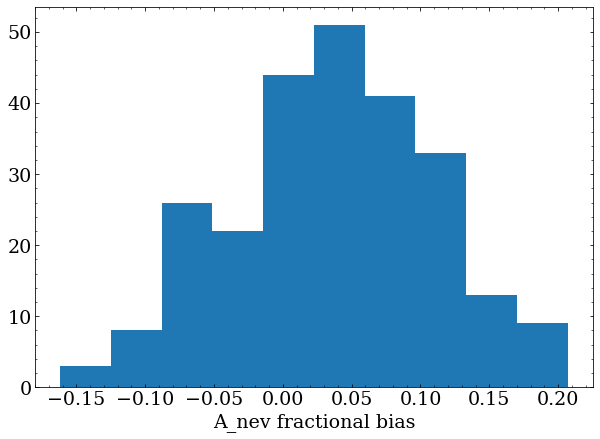

mean 0.001700973522467901 width 0.10306212584664612


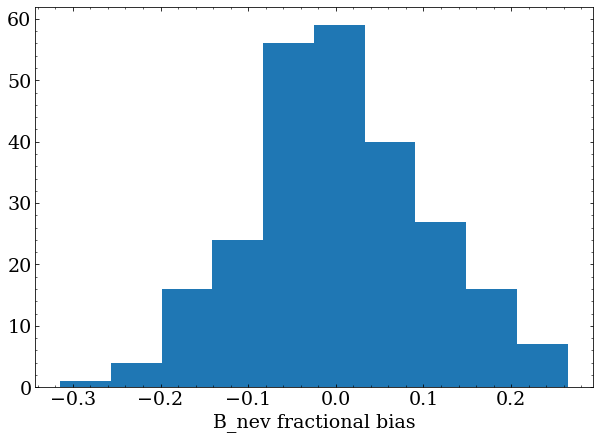

mean -0.013212688531266153 width 0.11077740564863266


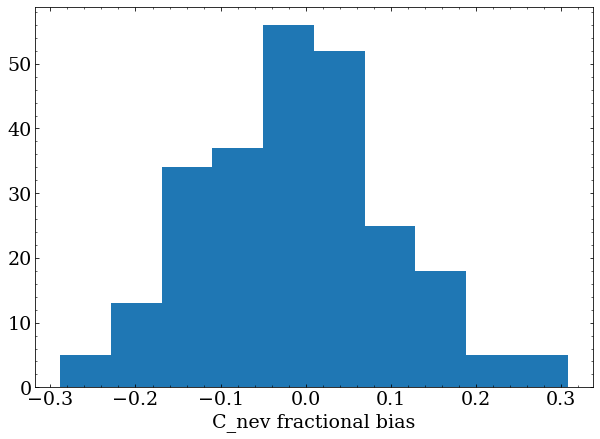

mean -0.06736499621678395 width 0.15786177933354983


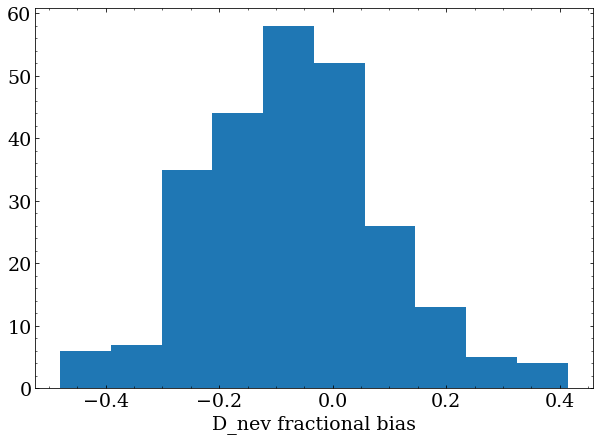

In [35]:
for p,b in zip(params,bias.T):
    print('mean',np.mean(b),'width',np.std(b))
    plt.hist(b)
    plt.xlabel('%s fractional bias'%p)
    plt.show()
    plt.close()

In [36]:
pull = np.asarray([[b/m.lower[p] if (b:=(m.params[p]-c)) < 0 else b/m.upper[p] for p,c in zip(params,central)] for m in minima])

0.4398112452934771 0.9415809713354708


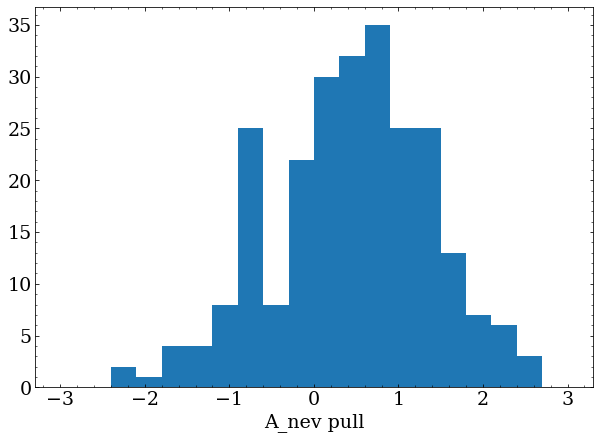

-0.053530815466941356 0.9498128974493526


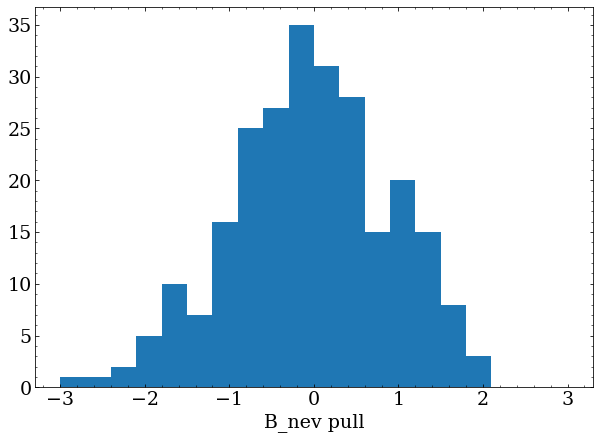

-0.2000283841122371 1.0290786821140014


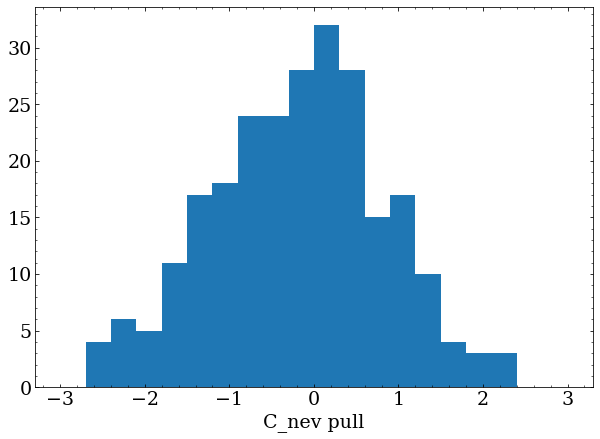

-0.5532905552206698 1.0867193459794173


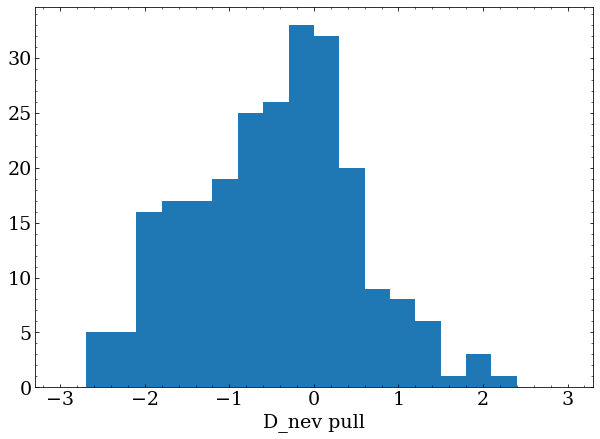

In [37]:
for p,u in zip(params,pull.T):
    print(np.mean(u),np.std(u))
    plt.hist(u,bins=np.linspace(-3,3,21))
    plt.xlabel('%s pull'%p)
    plt.show()
    plt.close()

Text(0, 0.5, 'Pull')

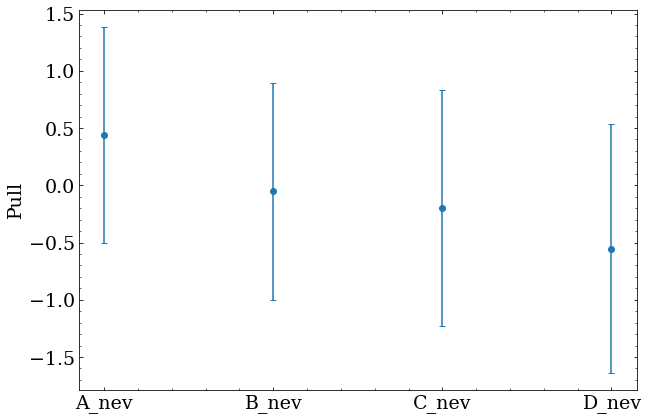

In [48]:
dat = np.asarray([(np.mean(u),np.std(u)) for u in pull.T])
par = np.arange(len(dat))
plt.errorbar(par,dat[:,0],yerr=dat[:,1],linestyle='none',marker='o')
plt.xticks(par,params)
plt.ylabel('Pull')

Text(0, 0.5, 'Bias')

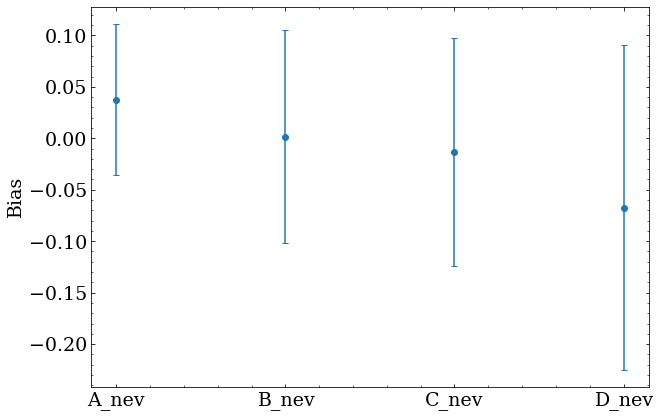

In [49]:
dat = np.asarray([(np.mean(u),np.std(u)) for u in bias.T])
par = np.arange(len(dat))
plt.errorbar(par,dat[:,0],yerr=dat[:,1],linestyle='none',marker='o')
plt.xticks(par,params)
plt.ylabel('Bias')